In [69]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import os
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import transformers

from tqdm import tqdm
import re

# Load tokenizer.

In [3]:
use_type_ids = True # Disables type_ids if the model does not support that feature.
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset.

In [4]:
squad_train_file_name = "train-v2.0.json"
squad_dev_file_name = "dev-v2.0.json"

triviaQA_train_file_name = "triviaqa_train.json"
triviaQA_dev_file_name = "triviaqa_dev.json"

## Convert TriviaQA to Squad form.

In [73]:
# Download the converter, the dataset, util functions from the official dataset repo.
# The scripts require about 15-20 munites to transform the files to the appropriate SQUAD form.

# This procedure can be disabled manually. Re-enable if needed.
convertion_needed = False

if convertion_needed:
    !wget https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
    !tar -xf triviaqa-rc.tar.gz
    !git clone https://github.com/amazon-research/qa-dataset-converter
    !git clone https://github.com/mandarjoshi90/triviaqa
    !cp qa-dataset-converter/triviaqa/triviaqa_to_squad.py triviaqa/
    !python triviaqa/triviaqa_to_squad.py --triviaqa_file qa/wikipedia-train.json --data_dir evidence/wikipedia/ --output_file triviaqa_train.json
    !python triviaqa/triviaqa_to_squad.py --triviaqa_file qa/wikipedia-dev.json --data_dir evidence/wikipedia/ --output_file triviaqa_dev.json

## Json format

In [5]:
def PrintJSONFormat(data, identetation, keyName, isList = False):
    # Prints the squad dataset format.
    left_string = keyName + " ->"
    ident_string = "    " * identetation

    if isList:
        left_string = left_string + " (list)"

    if isinstance(data, list) and data:
        # Skip list of items (not important for the format).
        PrintJSONFormat(data[0], identetation, keyName, True)
    elif isinstance(data, dict):
        keys = list(data.keys())
        print(ident_string + left_string, keys)
        for key in keys: # Iterate each key.
            PrintJSONFormat(data[key], identetation + 1, key)
    else:
        print(ident_string + keyName + ":", type(data).__name__)

def PrintFileFormat(file_name):
    file = open(file_name)
    json_obj = json.load(file)
    PrintJSONFormat(json_obj, 0, "Root")
    file.close()

In [75]:
# The following function is helpfull for understanding the dataset's format.
PrintFileFormat(squad_train_file_name)

Root -> ['version', 'data']
    version: str
    data -> (list) ['title', 'paragraphs']
        title: str
        paragraphs -> (list) ['qas', 'context']
            qas -> (list) ['question', 'id', 'answers', 'is_impossible']
                question: str
                id: str
                answers -> (list) ['text', 'answer_start']
                    text: str
                    answer_start: int
                is_impossible: bool
            context: str


## Number of answered / non answered questions.

In [6]:
def PrintStats(file_name):
    # Number of answered / not answered questions on the set.
    file = open(file_name)
    data_json = json.load(file)
    file.close()

    qas_count = 0
    no_answers = 0
    for topics in data_json['data']:
        for par in topics['paragraphs']:
            for sample in par['qas']:
                n = len(sample['answers'])
                qas_count += n
                if n == 0:
                    no_answers += 1

    print("File name:", file_name)
    print("Answered questions:", qas_count)
    print("Not answered questions:", no_answers)
    print("Total questions:", no_answers + qas_count)

PrintStats(squad_train_file_name)
print(" ")
PrintStats(squad_dev_file_name)

print("- - -")

PrintStats(triviaQA_train_file_name)
print(" ")
PrintStats(triviaQA_dev_file_name)

File name: train-v2.0.json
Answered questions: 86821
Not answered questions: 43498
Total questions: 130319
 
File name: dev-v2.0.json
Answered questions: 20302
Not answered questions: 5945
Total questions: 26247
- - -
File name: triviaqa_train.json
Answered questions: 77112
Not answered questions: 33535
Total questions: 110647
 
File name: triviaqa_dev.json
Answered questions: 9842
Not answered questions: 4387
Total questions: 14229


## Make pairs, calculate end idx.

In [7]:
def CalculateEndIndex(sample):
    # NOTE: we could extract multiple answers idxs. (The dataset contains 1 per answer)
    context = sample['context']
    answer = sample['answer']
    answer_start_idx = sample['answer_start']

    answer_len = len(answer)
    answer_end_idx = answer_start_idx + answer_len

    '''
    answer_from_idxs = context[answer_start_idx:answer_end_idx]
    if answer != answer_from_idxs:
        raise Exception("Invalid sentence idx", "Ans1:", answer, "Ans2", answer_from_idxs)
    '''

    return answer_end_idx

def MakePairs(json_obj):
    samples = []

    for topics in json_obj['data']:
        for paragraph in topics['paragraphs']:
            context = paragraph['context']
            for qas in paragraph['qas']:
                question = qas['question']
                # Edge case, plausible answers.
                keys = qas.keys()
                if "plausible_answers" in keys:
                    answers = []
                    #answers = qas["plausible_answers"]
                else:
                    answers = qas['answers']

                if not answers:
                    # Does not contain answers because the question is not
                    # able to be answered from the context. Provide a space
                    # string as the answer. (We consider empty string the true answer)
                    empty_sample = {
                        "text": " ",
                        "answer_start": context.find(" ")
                    }
                    answers.append(empty_sample)

                # Extract info into pairs.
                for answer in answers:
                    sample = {
                        "id": qas['id'],
                        "context": context,
                        "question": question,
                        "answer": answer['text'],
                        "answer_start": answer['answer_start']
                    }
                    sample['answer_end'] = CalculateEndIndex(sample)
                    samples.append(sample)

    # Return a list of dictionaries.  
    return samples

## Dataset class.

In [8]:
class SQUAD(Dataset):
    def __init__(self, file_name):
        file = open(file_name)
        data_json = json.load(file)
        file.close()

        # Split json into list of pairs.
        self.pairs = MakePairs(data_json)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        return pair

class CustomQuestions(Dataset):
    id_c = 0

    def __init__(self, contexts, questions):
        samples = []
        for context, question in zip(contexts, questions):
            sample = {
                "id": CustomQuestions.id_c,
                "context": context,
                "question": question,
                }
            samples.append(sample)
            CustomQuestions.id_c += 1
        
        self.pairs = samples

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        return pair

## Datasets creation.

In [9]:
squad_training_dataset = SQUAD(squad_train_file_name)
squad_dev_dataset = SQUAD(squad_dev_file_name)

# Same SQUAD class is used since the dataset is converted to the squad format.
triviaQA_training_dataset = SQUAD(triviaQA_train_file_name)
triviaQA_dev_dataset = SQUAD(triviaQA_dev_file_name)

## Histogram.

In [ ]:
def GetLens(data):
    data_loader = DataLoader(dataset=data, batch_size=1024)

    data_lengths = []
    for batch in data_loader:
        contexts = batch['context']
        questions = batch['question']
        tokenized_cq = tokenizer(list(contexts), list(questions))
        batch_input_ids = tokenized_cq['input_ids']

        for sample in batch_input_ids:
            sample_len = len(sample)
            data_lengths.append(sample_len)

    return data_lengths

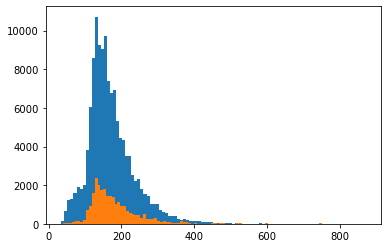

In [48]:
plt.hist(GetLens(squad_training_dataset), bins=100);
plt.hist(GetLens(squad_dev_dataset), bins=100);

Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors


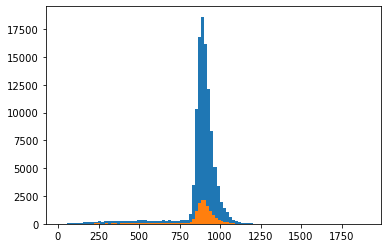

In [55]:
plt.hist(GetLens(triviaQA_training_dataset), bins=100);
plt.hist(GetLens(triviaQA_dev_dataset), bins=100);

In [20]:
def AnswersNotAffectedByTruncationPercentage(data):
    cut = 0
    ok = 0
    data_loader = DataLoader(dataset=data, batch_size=1024)

    for batch in data_loader:
        ends = batch['answer_end']

        for sample in ends:
            if sample <= 512:
                ok += 1
            else:
                cut += 1

    return ok / (cut + ok)

# Percentage of answers not affected by truncation.
print(triviaQA_train_file_name, int(AnswersNotAffectedByTruncationPercentage(triviaQA_training_dataset) * 100), "%")
print(triviaQA_dev_file_name, int(AnswersNotAffectedByTruncationPercentage(triviaQA_dev_dataset) * 100), "%")

triviaqa_train.json 69 %
triviaqa_dev.json 70 %


# Utility functions.

## Get answer.

In [49]:
def GetStartEnd(starts, ends):
    # Maximize propabilities while keeping end > start.
    # Following brute force method.

    sums = []
    start_i = 0
    for start in starts:
        end_i = 0
        for end in ends:
            sum = start + end

            # Skip invalid pairs.
            if end >= start:
                element = (sum, start_i, end_i)
                sums.append(element)

            end_i += 1
        start_i += 1

    max_element = max(sums, key=lambda s: s[0])
    return max_element[1], max_element[2]


def GetAnswer(input_ids, starts, ends):
    # NOTE: way too slow.
    #start, end = GetStartEnd(starts, ends)

    start = torch.argmax(starts)
    end = torch.argmax(ends)
    tokenized_context = tokenizer.convert_ids_to_tokens(input_ids)

    # Join list of words.
    answer = " ".join(tokenized_context[start:end+1])
    # Concat subwords.
    answer = re.sub(r"( ##|##)", "", answer)
    return answer

## Save / Checkpoint.

In [57]:
def GetSaveName(epoch, prefix=""):
    save_name = prefix + "model_epoch" + str(epoch + 1)
    return "./saved_models/" + save_name


def LoadSavedModel(max_epochs, prefix=""):
    # Loop through the epochs in reverse order. 
    # Trying to find the most trained checkpoint.
    for epoch in reversed(range(max_epochs)):
        save_name = GetSaveName(epoch, prefix)
        if os.path.isdir(save_name):
            finetuned_model = AutoModelForQuestionAnswering.from_pretrained(save_name)
            loaded_epoch = epoch + 1

            print(f"Loaded finetuned model trained with {loaded_epoch} epochs")
            return finetuned_model, loaded_epoch

    raise Exception("Model not found.")

## Subset.

In [51]:
#Since the dataset is too big we can take a subset for faster training. (Ended up not being used)
def GetSubset(full_dataset, percentage):
    full_size = len(set)
    new_size = int(percentage * full_size)
    discard_size = full_size - new_size
    new_dataset, _ = torch.utils.data.random_split(full_dataset, [new_size, discard_size])
    return new_dataset

## Training.

In [52]:
def BatchTokenization(contexts, questions, max_length):
    tokens = tokenizer(
        list(contexts),
        list(questions),
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    return tokens


def UpdateStartEnd(tokenized_cq, answers_start, answers_end):
    new_answers_start = []
    new_answers_end = []

    # Update start / end indices to match real sentences.
    for i, (start, end) in enumerate(zip(answers_start, answers_end)):
        new_start = tokenized_cq.char_to_token(i, start)
        if new_start is None:
            new_start = tokenizer.model_max_length
        new_answers_start.append(new_start)

        new_end = tokenized_cq.char_to_token(i, end)
        curr_count = 1
        while new_end is None:
            new_end = tokenized_cq.char_to_token(i, end-curr_count)
            curr_count += 1
        new_answers_end.append(new_end)

    return new_answers_start, new_answers_end


def ModelOutput(model, max_length, contexts, questions, answers_start=None, answers_end=None):
    tokenized_cq = BatchTokenization(contexts, questions, max_length)
    batch_input_ids = tokenized_cq['input_ids'].to(device)
    batch_attention_mask = tokenized_cq['attention_mask'].to(device)

    # Only needed on training data.
    if answers_start != None and answers_end != None:
        new_answers_start, new_answers_end = UpdateStartEnd(tokenized_cq, answers_start, answers_end)
        answers_start = torch.tensor(new_answers_start).to(device)
        answers_end = torch.tensor(new_answers_end).to(device)
    
    # Forward.
    # Some model do not use token type ids. Disabled by global variable.
    if use_type_ids:
        batch_token_type_ids = tokenized_cq['token_type_ids'].to(device)
        output = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            token_type_ids=batch_token_type_ids,
            start_positions=answers_start,
            end_positions=answers_end
        )
    else:
        output = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            start_positions=answers_start,
            end_positions=answers_end
        )

    return output, batch_input_ids


def SetSeed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def TrainModel(model, args):
    # Main function arguments through a dictionary.
    starting_epoch = args['starting_epoch']
    n_epochs = args['n_epochs']
    lr = args['lr']
    max_length = args['max_length']
    training_data_loader = args['training_data_loader']
    name_prefix = args['name_prefix']

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop.
    for epoch in range(n_epochs - starting_epoch):
        # tqdm provides a progress bar.
        for batch in tqdm(training_data_loader):
            contexts = batch['context']
            questions = batch['question']
            answers_start = batch['answer_start'].to(device)
            answers_end = batch['answer_end'].to(device)

            output, _ = ModelOutput(model, max_length, contexts, questions, answers_start, answers_end)

            # Backward.
            optimizer.zero_grad()
            output.loss.backward()
            optimizer.step()

        # Checkpoint each epoch.
        model.save_pretrained(GetSaveName(starting_epoch + epoch, name_prefix))


def TryModel(args):
    batch_s = args['batch_s']
    training_set = args['training_set']
    load_saved_model = args['load_saved_model']
    max_epochs = args['n_epochs']
    name_prefix = args['name_prefix']

    # Set static seed to prevent random results from batch shufling.
    SetSeed(153)

    # Load previous checkpoint (if enabled).
    # If max_epochs > saved_epoch then training is continued from the last checkpoint.
    starting_epoch = 0
    if load_saved_model:
        model, starting_epoch = LoadSavedModel(max_epochs, name_prefix)
    else:
        model = AutoModelForQuestionAnswering.from_pretrained(model_name) 
    
    args['starting_epoch'] = starting_epoch
    curr_model = model.to(device)

    training_data_loader = DataLoader(dataset=training_set,
                                      batch_size=batch_s,
                                      shuffle=True,
                                      # num_workers=2
                                      )
    args['training_data_loader'] = training_data_loader

    # Using pretrained bert model.
    TrainModel(curr_model, args)

    return curr_model

## Predictions.

In [3]:
def CalculatePredictions(model, data, batch_s, max_length=None):
    # Create a dictionary with format <question_id:answer> for each question-context pair.
    with torch.no_grad():
        predictions = dict()

        model = model.to(device)
        data_loader = DataLoader(dataset=data, batch_size=batch_s)
        for batch in tqdm(data_loader):
            contexts = batch['context']
            questions = batch['question']
            qas_id = batch['id']
            
            output, inputs_ids = ModelOutput(model, max_length, contexts, questions)
            batch_start_logits = output['start_logits']
            batch_end_logits = output['end_logits']

            sample_zip = zip(batch_start_logits, batch_end_logits, inputs_ids, questions, qas_id, contexts)
            for start_logits, end_logits, input_ids, question, qas_id, context in sample_zip:
                answer = GetAnswer(input_ids, start_logits, end_logits)
                predictions[qas_id] = answer
                
                #print(question)
                #print(answer)
                #print("---")

        return predictions


def GetPredictionsName(prefix):
    return f"./{prefix}predictions.json"


def CreatePredictionsJSON(predictions, prefix):
    pred_file_name = GetPredictionsName(prefix)
    with open(pred_file_name, 'w') as file:
        json.dump(predictions, file)

# Setup cuda / cpu device

In [54]:
# If cuda is available GPU will be used for
# faster training. Restricted usage in colab.
run_gpu = True
if torch.cuda.is_available and run_gpu:
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using the CPU")
    device = torch.device("cpu")

transformers.logging.set_verbosity_error()

Using Cuda


# Squad2.

## Fine tuning.

In [60]:
squad_prefix = "squad_"
triviaQA_prefix = "triviaQA_"

TryModel({
    'name_prefix': squad_prefix,
    'load_saved_model': False,
    'training_set': squad_training_dataset,
    'n_epochs': 2,
    'batch_s': 24, # Make this smaller if vram problems occure.
    'lr': 3e-5, 
    'max_length': 384 # None for max
});

Loaded finetuned model trained with 2 epochs


## Create predictions file.

In [ ]:
squad_finetuned_model, _ = LoadSavedModel(2, squad_prefix)

predictions = CalculatePredictions(squad_finetuned_model, squad_dev_dataset, 8)
CreatePredictionsJSON(predictions, squad_prefix + squad_prefix)

predictions = CalculatePredictions(squad_finetuned_model, triviaQA_dev_dataset, 8)
CreatePredictionsJSON(predictions, squad_prefix + triviaQA_prefix)

## Custom questions / contexts.

In [66]:
contexts = [] 
questions = []

contexts.append('The modern Olympic Games are leading international multi-sport events in which thousands of athletes from around the world participate in various competitions. The Summer and Winter Games are each held in a different city every four years, offset from each other by two. Inspired by the ancient Greek Olympic Games, Pierre de Coubertin founded the International Olympic Committee (IOC) in 1894, leading to the first modern Games in 1896.')
questions.append('who invented the olympic games?')

contexts.append('SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.')
questions.append('How many questions does squad 1 contain?')

contexts.append('Elon Reeve Musk FRS is an entrepreneur and business magnate. He is the founder, CEO, and Chief Engineer at SpaceX; early-stage investor, CEO, and Product Architect of Tesla, Inc.; founder of The Boring Company; and co-founder of Neuralink and OpenAI.')
questions.append('Who is elon musk?')

contexts.append('I don’t trust stairs because they’re always up to somethin')
questions.append('Why dont i trust stairs?')

contexts.append('Tetris is a puzzle video game created by Soviet software engineer Alexey Pajitnov in 1984. It has been published by several companies for multiple platforms, most prominently during a dispute over the appropriation of the rights in the late 1980s.')
questions.append('When was tetris released?')

contexts.append('In competitive games, the piece colors are allocated to players by the organizers; in informal games, the colors are usually decided randomly, for example by a coin toss, or by one player concealing a white pawn in one hand and a black pawn in the other, and having the opponent choose. White moves first, after which players alternate turns, moving one piece per turn (except for castling, when two pieces are moved). A piece is moved to either an unoccupied square or one occupied by an opponent\'s piece, which is captured and removed from play. With the sole exception of en passant, all pieces capture by moving to the square that the opponent\'s piece occupies. Moving is compulsory; a player may not skip a turn, even when having to move is detrimental.')
questions.append('Who plays first in chess?')

contexts.append('George\'s dog is barking outside the house while George\'s wife is at the supermarket.')
questions.append("What is george\'s dog doing?")

contexts.append('Alex likes Susan')
questions.append("What is the wheather like?")

custom_set = CustomQuestions(contexts, questions)
custom_predictions = CalculatePredictions(squad_finetuned_model, custom_set, 8)

for i, q_id in enumerate(custom_predictions):
    print("Context:", custom_set[i]['context'])
    print("")
    print("Question:", custom_set[i]['question'])
    print("Answer:", custom_predictions[q_id])
    print("- - - -")

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Context: The modern Olympic Games are leading international multi-sport events in which thousands of athletes from around the world participate in various competitions. The Summer and Winter Games are each held in a different city every four years, offset from each other by two. Inspired by the ancient Greek Olympic Games, Pierre de Coubertin founded the International Olympic Committee (IOC) in 1894, leading to the first modern Games in 1896.

Question: who invented the olympic games?
Answer: pierre de coubertin
- - - -
Context: SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

Question: How many questions does squad 1 contain?
Answer: 100 , 000
- - - -
Context: Elon Reeve Musk FRS is an entrepreneur and

# TriviaQA

## Fine tuning.

In [ ]:
TryModel({
    'name_prefix': triviaQA_prefix,
    'load_saved_model': False,
    'training_set': triviaQA_training_dataset,
    'n_epochs': 2,
    'batch_s': 24, # Make this smaller if vram problems occure.
    'lr': 3e-5, 
    'max_length': 384 # None for max
});

## Create predictions file.

In [ ]:
triviaQA_finetuned_model, _ = LoadSavedModel(2, triviaQA_prefix)

predictions = CalculatePredictions(triviaQA_finetuned_model, triviaQA_dev_dataset, 8)
CreatePredictionsJSON(predictions, triviaQA_prefix + triviaQA_prefix)

predictions = CalculatePredictions(triviaQA_finetuned_model, squad_dev_dataset, 8)
CreatePredictionsJSON(predictions, triviaQA_prefix + squad_prefix)

# Predictions evaluation.
The following convention corresponds to the tuples <model, dataset>

## Squad2-Squad2

In [33]:
predictions_name = GetPredictionsName(squad_prefix + squad_prefix)
squad_squad_accuracy = !python ./evaluate-v2.0.py $squad_dev_file_name $predictions_name
squad_squad_accuracy

['{',
 '  "exact": 64.51612903225806,',
 '  "f1": 69.4742652718149,',
 '  "total": 11873,',
 '  "HasAns_exact": 61.11673414304993,',
 '  "HasAns_f1": 71.04722529896368,',
 '  "HasAns_total": 5928,',
 '  "NoAns_exact": 67.90580319596299,',
 '  "NoAns_f1": 67.90580319596299,',
 '  "NoAns_total": 5945',
 '}']

## Squad2-TriviaQA

In [37]:
predictions_name = GetPredictionsName(squad_prefix + triviaQA_prefix)
squad_trivia_accuracy = !python ./evaluate-v2.0.py $triviaQA_dev_file_name $predictions_name
squad_trivia_accuracy

['{',
 '  "exact": 36.43966547192353,',
 '  "f1": 41.75575469008161,',
 '  "total": 14229,',
 '  "HasAns_exact": 25.16764885185938,',
 '  "HasAns_f1": 32.853346218773474,',
 '  "HasAns_total": 9842,',
 '  "NoAns_exact": 61.72783223159335,',
 '  "NoAns_f1": 61.72783223159335,',
 '  "NoAns_total": 4387',
 '}']

## TriviaQA-TriviaQA

In [36]:
predictions_name = GetPredictionsName(triviaQA_prefix + triviaQA_prefix)
trivia_trivia_accuracy = !python ./evaluate-v2.0.py $triviaQA_dev_file_name $predictions_name
trivia_trivia_accuracy

['{',
 '  "exact": 52.75845105067116,',
 '  "f1": 56.193190058036436,',
 '  "total": 14229,',
 '  "HasAns_exact": 43.131477342003656,',
 '  "HasAns_f1": 48.097226309266205,',
 '  "HasAns_total": 9842,',
 '  "NoAns_exact": 74.35605197173467,',
 '  "NoAns_f1": 74.35605197173467,',
 '  "NoAns_total": 4387',
 '}']

## TriviaQA-Squad2

In [29]:
predictions_name = GetPredictionsName(triviaQA_prefix + squad_prefix)
trivia_squad_accuracy = !python ./evaluate-v2.0.py $squad_dev_file_name $predictions_name
trivia_squad_accuracy

['{',
 '  "exact": 30.447233218226227,',
 '  "f1": 34.253412183549884,',
 '  "total": 11873,',
 '  "HasAns_exact": 27.10863697705803,',
 '  "HasAns_f1": 34.73191006330798,',
 '  "HasAns_total": 5928,',
 '  "NoAns_exact": 33.77628259041211,',
 '  "NoAns_f1": 33.77628259041211,',
 '  "NoAns_total": 5945',
 '}']

## Final table

In [38]:
def GetF1(accuracy_result):
    # Result stored as list of strings.
    dict_string = " ".join(accuracy_result)
    accuracy_dictionary = json.loads(dict_string)
    return accuracy_dictionary['f1']

squad_squad_f1 = GetF1(squad_squad_accuracy)
squad_trivia_f1 = GetF1(squad_trivia_accuracy)
trivia_trivia_f1 = GetF1(trivia_trivia_accuracy)
trivia_squad_f1 = GetF1(trivia_squad_accuracy)

dataset_names = ['squad2', 'triviaQA']
results = pd.DataFrame([[squad_squad_f1, squad_trivia_f1],[trivia_squad_f1, trivia_trivia_f1]], dataset_names, dataset_names)
display(results)

,squad2,triviaQA
squad2,69.474265,41.755755
triviaQA,34.253412,56.193190


# Zip saved models.

In [ ]:
!tar -zcvf saved_models.tar.gz ./saved_models